In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import pickle
import sbi.utils as utils
import torch
from sbi.inference import ImportanceSamplingPosterior
from scipy.special import logsumexp

from collective_posterior import CollectivePosterior

import matplotlib as mpl
plt.rcParams['figure.dpi'] = 600

import warnings
warnings.simplefilter('ignore', FutureWarning)



# Prior doesn't have to be identical to network's prior (here it is)
prior_min = np.log10(np.array([1e-2,1e-7,1e-8]))
prior_max = np.log10(np.array([1,1e-2,1e-2]))
prior = utils.BoxUniform(low=torch.tensor(prior_min), 
                         high=torch.tensor(prior_max))
posterior_chuong = pickle.load(open(f'posteriors/posterior_chuong.pkl', 'rb'))
# posterior_lauer = pickle.load(open(f'posteriors/posterior_lauer.pkl', 'rb'))
n_eval = 300 # N used to calculate normalizng constant
epsilon = -150 # choice is detailed later
log_Cs = pd.read_csv('posteriors/log_Cs.csv', index_col=0) # pre-saved normalizing constant
sample_df = pd.read_csv('maps/collective_posterior_samples.csv', index_col=0) # pre-saved samples

collective_posteriors = {}

lines = ['wt', 'ltr', 'ars', 'all']
for line in lines:
    amortized_posterior = posterior_lauer if line=='lauer' else posterior_chuong
    Xs = pd.read_csv(f'empirical_data/{line}.csv', index_col=0) # observations
    Xs = torch.tensor(np.array(Xs), dtype=torch.float32)
    log_C = float(log_Cs.loc[line,str(epsilon)]) # normalizing constant
    op = CollectivePosterior(prior, amortized_posterior, Xs, n_eval, log_C, epsilon)
    samples = sample_df[sample_df['line']==line].iloc[:,1:] # only parameter values
    op.samples = torch.tensor(np.array(samples,dtype='float64')).reshape(len(samples),3)
    collective_posteriors[line] = op # to use throughout the notebook
    
rep_colors = {'wt':"black", 'ltr':"#6699cc", 'ars': "#e26d5c", 'all':"#DEBD52", "lauer": "grey"}
label_dict = {'wt': 'Wildtype', 'ltr': 'LTRΔ', 'ars': 'ARSΔ', 'all': 'ALLΔ', 'lauer': 'Lauer'}

In [2]:
collective_posteriors['all'].sample(n_samples=100)

tensor([[-0.9078, -5.0002, -5.2874],
        [-0.9012, -5.0305, -5.3573],
        [-0.8941, -5.0859, -5.2246],
        [-0.8922, -5.1239, -5.2404],
        [-0.8987, -5.0258, -5.1706],
        [-0.8987, -5.0579, -5.3344],
        [-0.9063, -4.9976, -5.2903],
        [-0.8960, -5.0602, -5.1678],
        [-0.8985, -5.0864, -5.2368],
        [-0.9032, -5.0486, -5.2746],
        [-0.8897, -5.1242, -5.3090],
        [-0.9022, -5.0270, -5.2796],
        [-0.9097, -4.9833, -5.2252],
        [-0.8991, -5.0879, -5.2569],
        [-0.8940, -5.0731, -5.3016],
        [-0.9063, -5.0007, -5.3351],
        [-0.9002, -5.0572, -5.2680],
        [-0.9080, -5.0085, -5.1694],
        [-0.8935, -5.1101, -5.2407],
        [-0.9005, -5.0373, -5.2536],
        [-0.9063, -5.0023, -5.1840],
        [-0.9002, -5.0229, -5.1464],
        [-0.8920, -5.1271, -5.2595],
        [-0.8948, -5.0741, -5.3070],
        [-0.9000, -5.0579, -5.3993],
        [-0.9063, -4.9859, -5.3238],
        [-0.8909, -5.1375, -5.2310],
 

<Axes: title={'center': 'Previous Sampler'}>

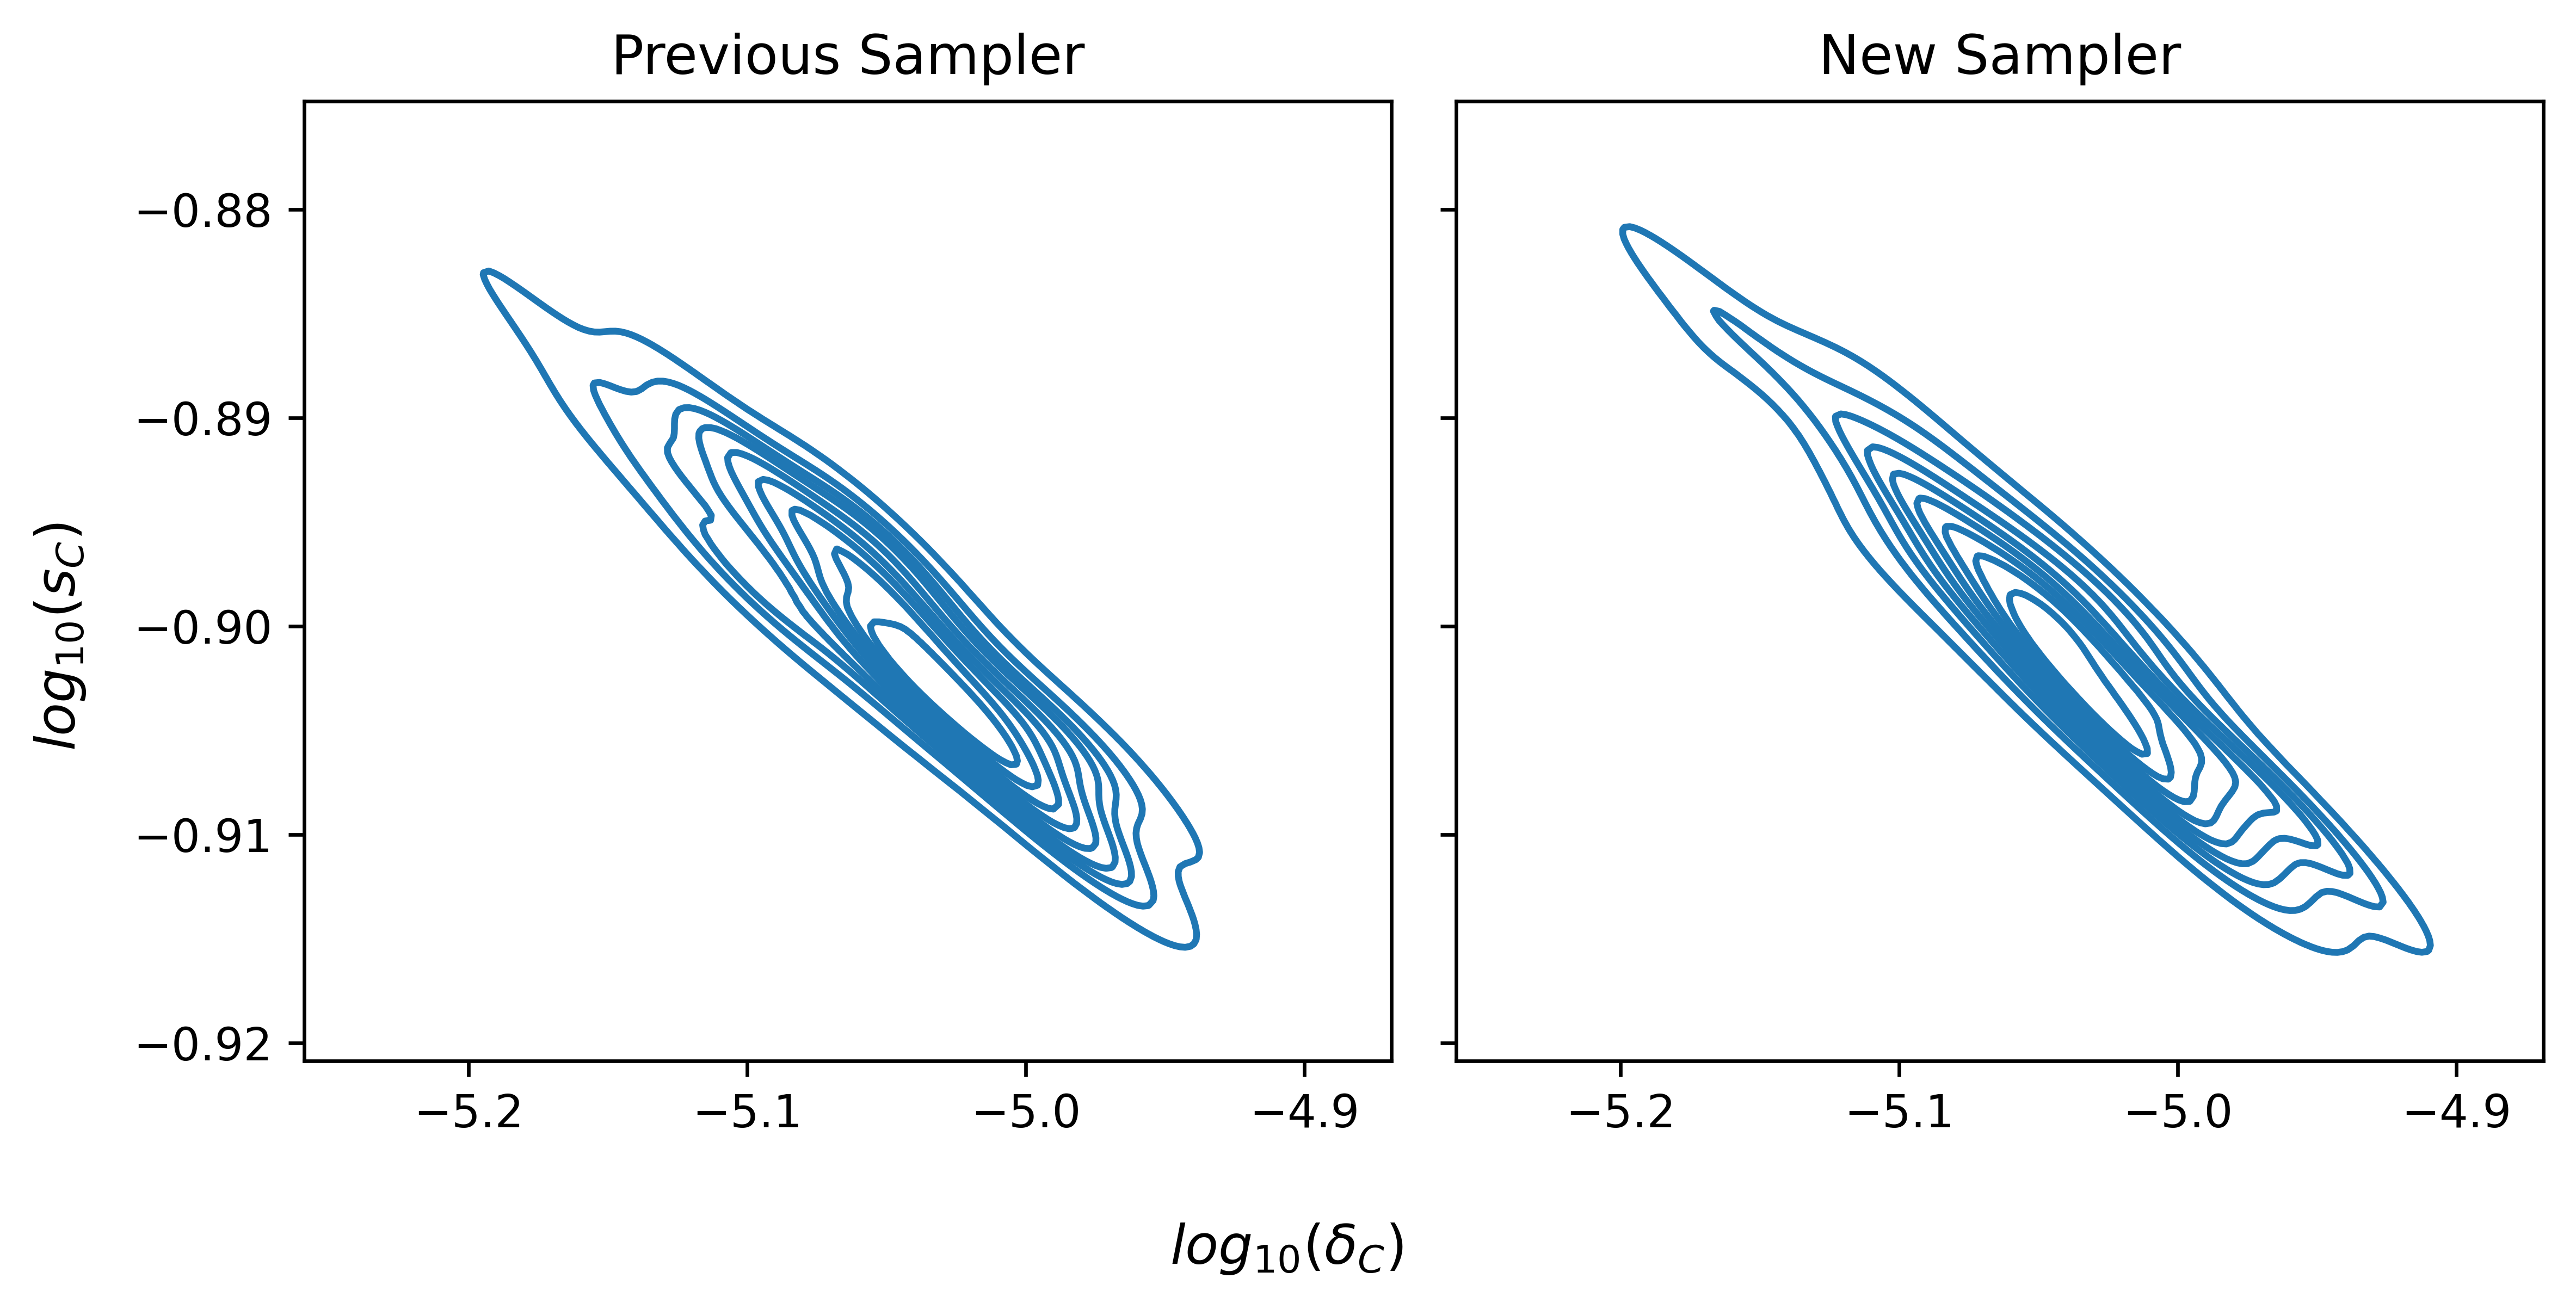

In [6]:
from seaborn import kdeplot
c = collective_posteriors['all']
samples = c.sample(100,keep=False)
fig,ax = plt.subplots(1,2, tight_layout = True, figsize=(8,4), sharex=True, sharey=True)
fig.supxlabel('$log_{10}(δ_C)$')
fig.supylabel('$log_{10}(s_C)$')
ax[0].set_title('Previous Sampler')
ax[1].set_title('New Sampler')
kdeplot(ax = ax[1], x = samples[:,1], y = samples[:,0])
s = c.samples
kdeplot(ax = ax[0], x = s[:,1], y = s[:,0])

In [17]:
def sample_mcmc(collective_posterior, samples=200):
    res = torch.empty((samples,len(collective_posterior.prior.mean)))
    func = collective_posterior.log_prob
    good_ones = 0
    ap = collective_posterior.amortized_posterior
    init_samps = ap.set_default_x(collective_posterior.Xs.iloc[3,:]).sample((10000,))
    x = init_samps[collective_posterior.log_prob(init_samps).argmax()]
    print(x, func(x))
    samps = torch.empty((samples,len(x)))
    while good_ones < samples:
        x_tag = x + torch.tensor(np.random.normal(0,0.05*np.abs(x.min()),(1,3)), dtype=torch.float32)
        ratio = func(x_tag) - func(x) # posterior ratio
        if np.log(np.random.random()) < ratio: # transition
            x = x_tag
            good_ones += 1
            samps[good_ones-1,:] = x_tag
            print(x_tag, func(x_tag))
    return samps
    

cp = collective_posteriors['ars']
res = sample_mcmc(cp,10)
plt.hist(res[:,1], color='blue')
res

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

tensor([-0.8089, -5.5235, -5.6008]) tensor([-62.0430])
tensor([[-0.8412, -5.5624, -5.2857]]) tensor([-37.1443])
tensor([[-0.8230, -5.7035, -5.4626]]) tensor([-26.6417])
tensor([[-0.8517, -5.5161, -5.3064]]) tensor([3.2327])


KeyboardInterrupt: 

In [5]:
from cnv_simulation_initial_beneficial import CNVsimulator_simpleWF
# Simulation & model parameters
reps = 1
chuong_generation = pd.read_csv(f'Chuong_116_gens.txt', delimiter = ', ', engine='python')
chuong_generation = chuong_generation.columns.astype('int')
N = 3.3e8

# Simulator function - generates a posterior prediction given model parameters
def CNVsimulator(cnv_params, generation, reps=1):
    cnv_params = np.asarray(torch.squeeze(cnv_params,0))
    states = CNVsimulator_simpleWF(reps = reps, N=N, generation=generation, seed=None, parameters=cnv_params)
        
    return states

test_samples = posterior_chuong.prior.sample((100,))
# acc = torch.empty((len(test_samples)), len(test_samples[0]))
# for i in range(len(test_samples)):
#     test = test_samples[i]
#     x = pd.DataFrame(CNVsimulator(test, chuong_generation, reps=8))
#     n_eval = 20
#     epsilon = -150.
#     log_C = 10000
#     op = CollectivePosterior(posterior_chuong.prior, posterior_chuong, x, n_eval, log_C, epsilon)
#     m = sample_mcmc(op,2).mean(axis=0)
#     print(m, test)
#     acc[i] = torch.log10(m/test)
# hst(acc[:,1])

In [4]:
test_samples

tensor([[-0.2453, -4.0328, -5.7759],
        [-1.8639, -3.9535, -2.5227],
        [-1.6261, -3.6246, -3.2149],
        [-1.0421, -2.9651, -7.9925],
        [-0.1538, -3.5453, -7.4976],
        [-1.1563, -6.2560, -7.3858],
        [-1.9145, -1.3157, -5.8380],
        [-0.8182, -2.1610, -2.0669],
        [-1.1452, -3.5463, -7.9565],
        [-1.5842, -1.2212, -3.3718],
        [-0.9370, -0.6302, -6.6107],
        [-0.3760, -1.3363, -4.0953],
        [-1.3001, -2.6828, -1.8639],
        [-0.1059, -6.9148, -1.4937],
        [-1.1519, -0.8355, -6.7082],
        [-0.6514, -1.0736, -3.0377],
        [-1.3658, -3.0760, -5.7766],
        [-0.5767, -4.3354, -1.4609],
        [-1.9063, -1.8311, -7.0400],
        [-0.6224, -3.0406, -1.6121],
        [-0.1000, -6.9559, -2.4702],
        [-1.6875, -3.0915, -5.1815],
        [-0.7448, -2.4332, -5.5217],
        [-0.9943, -1.8583, -2.1141],
        [-1.8072, -6.3417, -6.1717],
        [-1.4378, -6.8207, -6.4349],
        [-1.0530, -3.6032, -2.9807],
 

In [8]:
potential_fn = posterior_chuong.potential_fn
posterior_imp = ImportanceSamplingPosterior(potential_fn, proposal = posterior_chuong.prior)


samp = test_samples[5]
X = torch.tensor(CNVsimulator(samp, chuong_generation, reps=8), dtype=torch.float32)
x = X[0]
samps = posterior_chuong.set_default_x(x).sample((50,))
print(samps)
m = samps.mean(axis=0)
print(posterior_imp.set_default_x(x).log_prob(m))

X = pd.DataFrame(X)
cp = CollectivePosterior(posterior_chuong.prior, posterior_chuong, X, 20, 1, -150)
print(cp.get_log_C())
print(cp.log_prob(m))

Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

tensor([[-1.1876, -6.1083, -5.0209],
        [-1.1746, -6.1222, -4.4351],
        [-1.1512, -6.2415, -6.2884],
        [-1.1316, -6.4375, -4.6994],
        [-1.2030, -5.9807, -4.7291],
        [-1.1618, -6.1766, -6.0731],
        [-1.1571, -6.2285, -4.7332],
        [-1.1902, -6.0457, -7.8540],
        [-1.1658, -6.2725, -6.4971],
        [-1.1998, -6.0468, -4.3550],
        [-1.1735, -6.1429, -6.0800],
        [-1.1682, -6.2012, -7.9848],
        [-1.2094, -5.9512, -6.3239],
        [-1.1365, -6.3729, -6.0309],
        [-1.1631, -6.1907, -5.8702],
        [-1.1808, -6.0348, -4.1129],
        [-1.2078, -5.9514, -5.5558],
        [-1.1861, -6.0827, -5.4872],
        [-1.1890, -6.0432, -6.4756],
        [-1.1697, -6.1886, -5.8162],
        [-1.1977, -6.0629, -6.8218],
        [-1.1309, -6.4025, -6.5960],
        [-1.1905, -6.0853, -6.2574],
        [-1.1710, -6.1538, -6.7042],
        [-1.1623, -6.1914, -4.1108],
        [-1.1528, -6.2982, -5.2474],
        [-1.1706, -6.1711, -5.1543],
 

In [9]:
print(cp.individual_log_probs(m))

[5.35129547 4.76373339 5.2706089  4.47724247 4.97159195 5.21184778
 5.2655077  4.74346113]


In [13]:
cp = collective_posteriors['ars']
for i in range(len(cp.Xs)):
    x = torch.tensor(cp.Xs.iloc[i,:], dtype=torch.float32)
    samps = posterior_imp.set_default_x(x).sample((1000,))
    probs = cp.log_prob(samps)
    print(probs.max(), samps[probs.argmax()])

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
cp.individual_log_probs(torch.tensor(cp.samples[0], dtype=torch.float32))

/tmp/ipykernel_2134589/954010218.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cp.individual_log_probs(torch.tensor(cp.samples[0], dtype=torch.float32))


array([ -771.44812012,  -843.29052734,   -25.3791256 ,  -354.32244873,
       -1901.20422363,  -651.91107178,   -19.01423454])

In [12]:
cp.log_prob(cp.prior.base_dist.low)

tensor([-1203.6461])

In [5]:
c = collective_posteriors['all']
samples = c.sample(5)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
samples

tensor([[-0.8913, -5.1315, -5.3128],
        [-0.8902, -5.1145, -5.3248],
        [-0.8870, -5.1702, -5.2649],
        [-0.9058, -5.0078, -5.2948],
        [-0.8997, -5.0654, -5.2083]])

<Axes: title={'center': 'Previous Sampler'}>

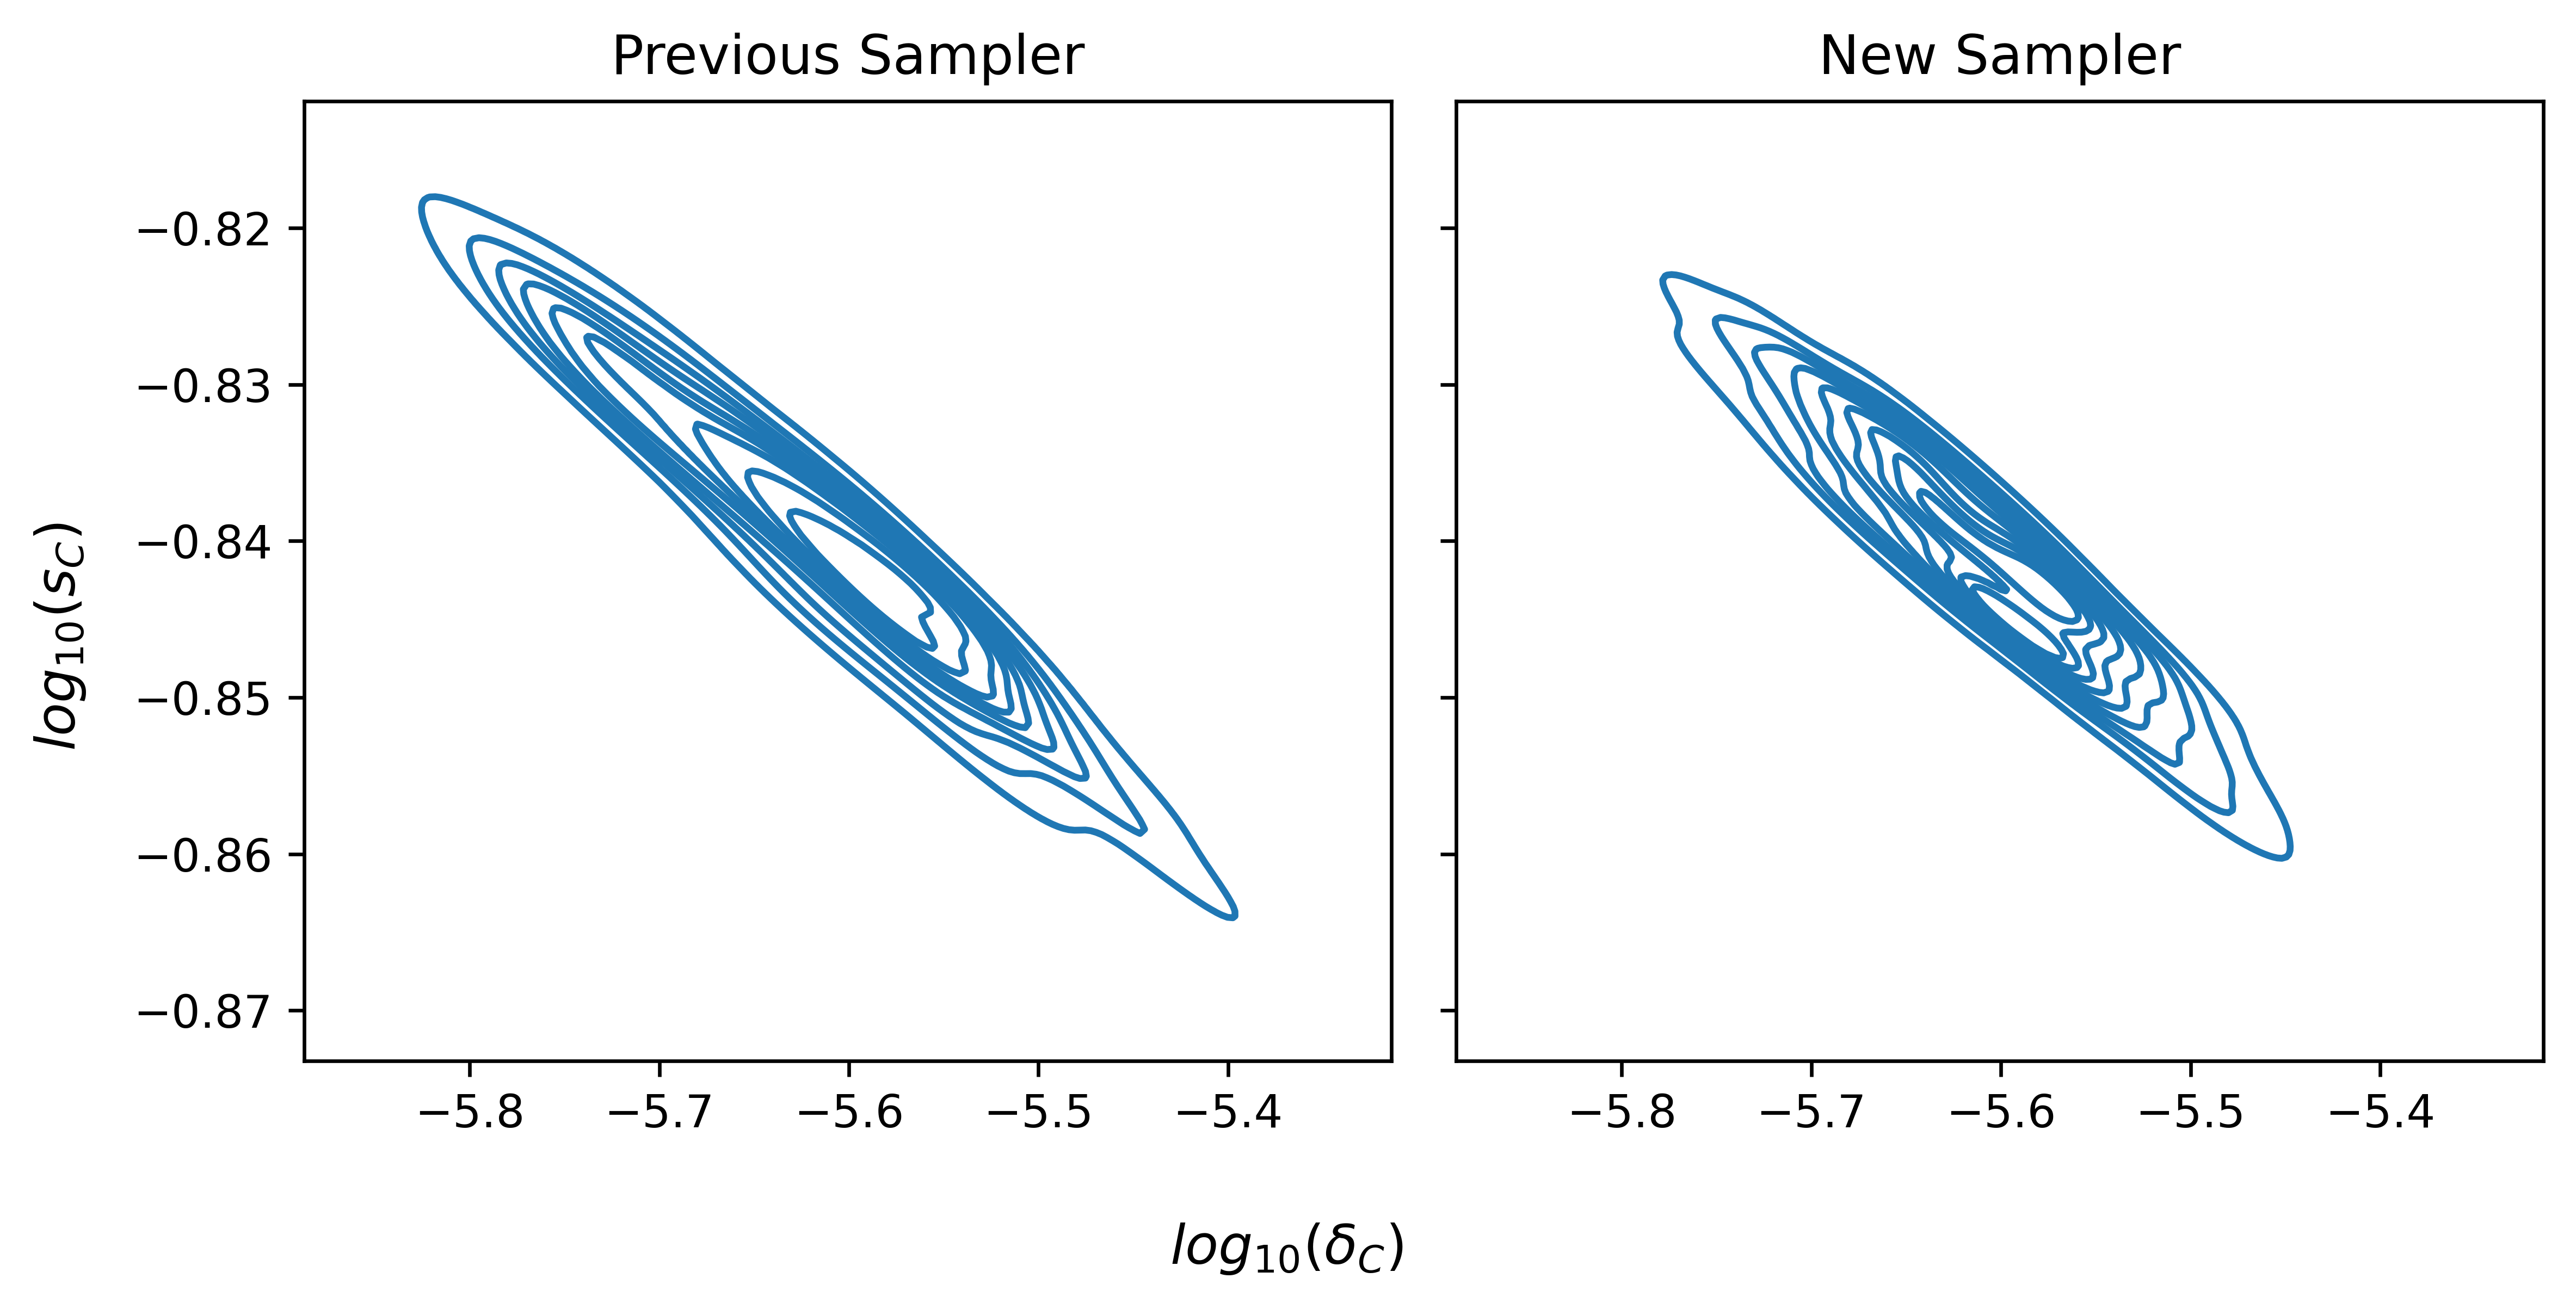

In [37]:
def sample_around(cp, theta, jump):
    dist =  torch.distributions.multivariate_normal.MultivariateNormal(theta, torch.diag(torch.tensor([0.05,0.05,0.05])))
    cands = dist.sample((jump,))
    probs = cp.log_prob(cands)
    baseline = torch.rand((len(cands),))
    res = cands[probs>baseline]
    return res


def final_sample(cp, n_samples, jump=int(1e5), keep=True):
    theta = c.rejection_sample(1,keep=False)[0]
    samples = torch.empty((n_samples,len(theta)))
    cur = 0
    while cur<n_samples:
        samps = sample_around(cp,theta,jump)
        how_many = len(samps)
        if cur+how_many > n_samples:
            how_many = n_samples-cur
        if how_many>0:
            samples[cur:cur+how_many,:] = samps[:how_many,:]
            cur += how_many
    if keep:
        cp.samples = samples
    return samples
    


c = collective_posteriors['ars']
samples = final_sample(c,n_samples=500, keep=False)

from seaborn import kdeplot
fig,ax = plt.subplots(1,2, tight_layout = True, figsize=(8,4), sharex=True, sharey=True)
fig.supxlabel('$log_{10}(δ_C)$')
fig.supylabel('$log_{10}(s_C)$')
ax[0].set_title('Previous Sampler')
ax[1].set_title('New Sampler')
kdeplot(ax = ax[1], x = samples[:,1], y = samples[:,0])
s = c.samples
kdeplot(ax = ax[0], x = s[:,1], y = s[:,0])

In [4]:
def cp_sample(cp, n_samples, jump = int(10**4), keep=True):
    samples = torch.empty((n_samples,len(cp.prior.mean)))
    current = 0
    sampled = 0
    pot = cp.amortized_posterior.potential_fn
    imp = ImportanceSamplingPosterior(pot, proposal=cp.prior)
    while sampled < len(samples):
        for i in range(len(cp.Xs)):
            if sampled >= len(samples):
                break
            cands = imp.set_default_x(cp.Xs[i,:]).sample((jump,))
            probs = cp.log_prob(cands)
            # rands = torch.log(torch.rand((len(cands),)))
            good = cands[probs.argmax()]
            samples[current:current+1] = good
            current = current+1
            sampled += 1
    if keep:
        cp.samples = samples
    return samples


In [20]:
%%capture
new_samps = cp_sample(c,100, jump=10000, keep=False)

<Axes: title={'center': 'Previous Sampler'}>

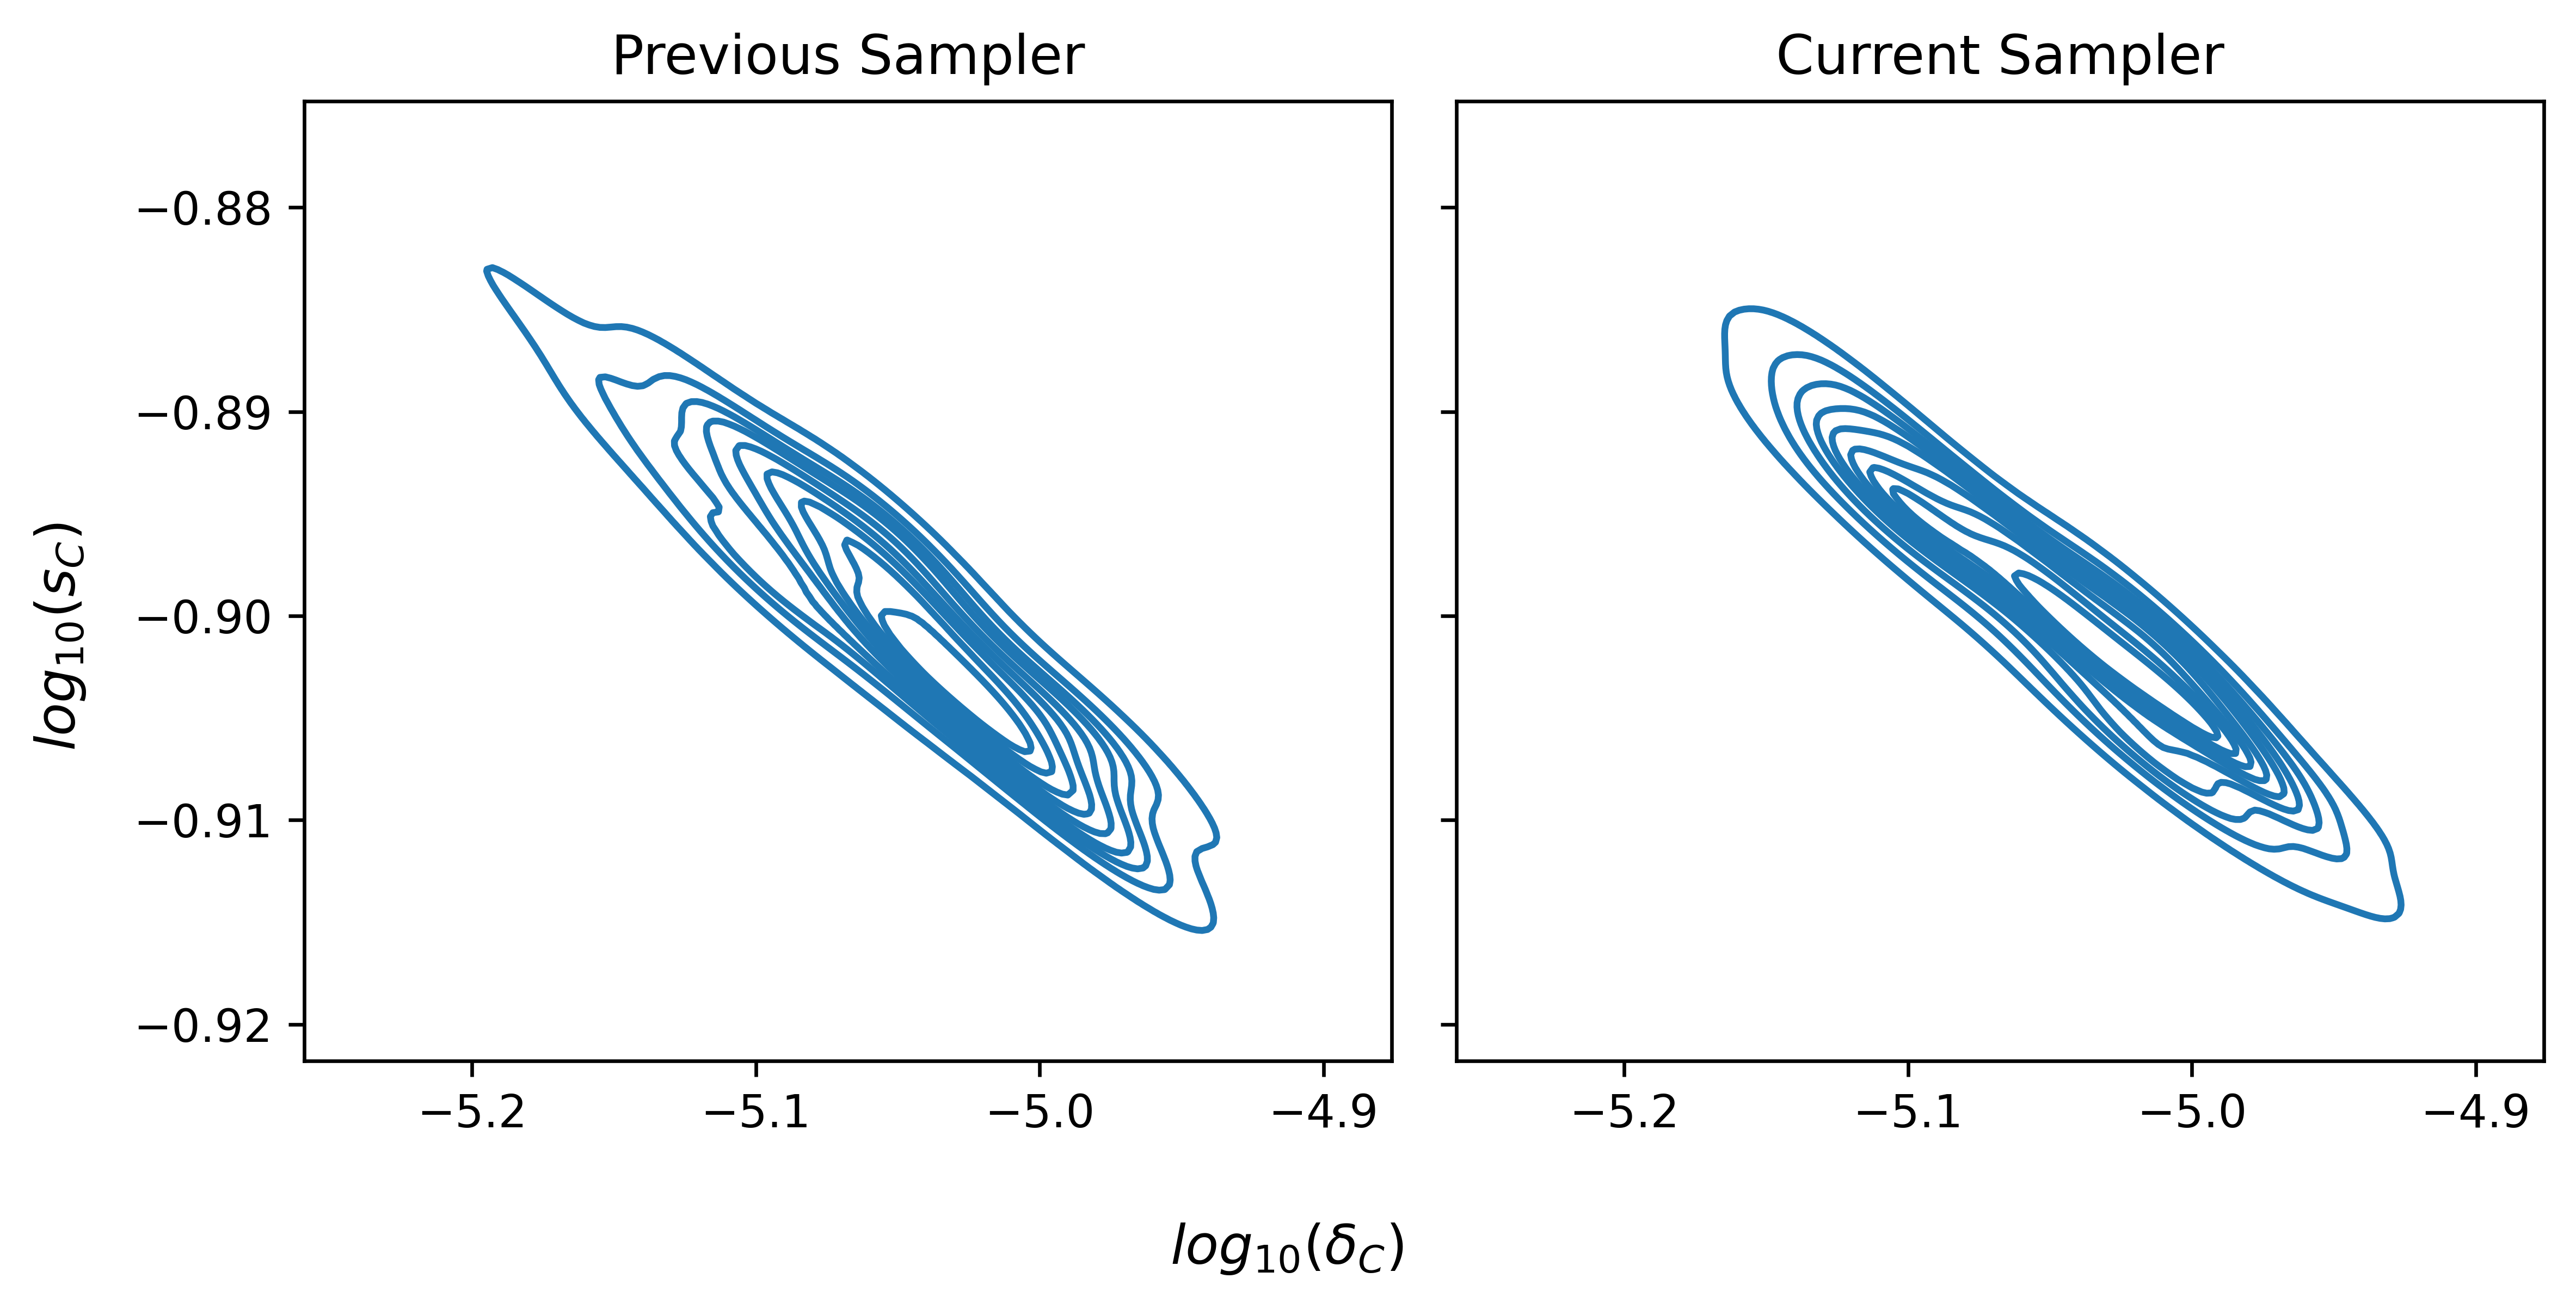

In [30]:
from seaborn import kdeplot
fig,ax = plt.subplots(1,2, tight_layout = True, figsize=(8,4), sharex=True, sharey=True)
fig.supxlabel('$log_{10}(δ_C)$')
fig.supylabel('$log_{10}(s_C)$')
ax[0].set_title('Previous Sampler')
ax[1].set_title('Current Sampler')
kdeplot(ax = ax[1], x = curr_samps[:,1], y = curr_samps[:,0])
s = c.samples
kdeplot(ax = ax[0], x = s[:,1], y = s[:,0])

In [26]:
from cnv_simulation_initial_beneficial import CNVsimulator_simpleWF

generations = np.array(pd.read_csv('Chuong_116_gens.txt').columns).astype('int')
N = 3.3e8
seed = None
def simulator(theta):
    return CNVsimulator_simpleWF(parameters=theta, reps=1, generation=generations, N=N, seed=seed)

theta = np.array([-1.0,-4.0,-5.0])

n = 5
D = np.zeros(shape=(n,len(generations)))

for i in range(n):
    D[i,:] = simulator(theta)

def noiser(x):
    val = np.random.normal(0,0.01)+x
    if val > 1:
        val=1
    elif val < 0:
        val=0
    return val
vfunc = np.vectorize(noiser)
vfunc(D)



array([[0.        , 0.02318545, 0.00174676, 0.04187914, 0.10185098,
        0.21142305, 0.35947213, 0.63575177, 0.81696275, 0.88743557,
        0.95734325, 0.98077899],
       [0.        , 0.00626809, 0.01517844, 0.03972922, 0.11980891,
        0.1966951 , 0.35525885, 0.62639228, 0.7981335 , 0.89448691,
        0.95796563, 0.98133104],
       [0.00131393, 0.        , 0.01912602, 0.0305567 , 0.07839704,
        0.21131117, 0.35657632, 0.64035171, 0.78987057, 0.86380418,
        0.94222828, 0.97134566],
       [0.0158435 , 0.0011805 , 0.00371993, 0.02526081, 0.11603373,
        0.197143  , 0.34975826, 0.65727399, 0.80823469, 0.87633948,
        0.95680993, 0.98457375],
       [0.00355575, 0.        , 0.02012344, 0.01109941, 0.08211568,
        0.21363308, 0.34896276, 0.65989281, 0.78557093, 0.92455985,
        0.97418879, 0.97437549]])

In [65]:

# print(samps[lp.argmax()], lp.max(), lp.min())
# cp.log_prob(t)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -9806.01953125
        x: [-1.041e+00 -3.779e+00 -3.926e+00]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00]
 hess_inv: [[1 0 0]
            [0 1 0]
            [0 0 1]]
     nfev: 4
     njev: 1

In [2]:
%%time
from scipy.optimize import minimize
s = torch.tensor(np.array(Xs), dtype=torch.float32)
cp = collective_posteriors['wt']

def func(theta):
    t = torch.tensor(theta, dtype=torch.float32)
    return -1*cp.log_prob(t)

samples = torch.empty((100,3))
cur = 0
while cur<10:
    samps = prior.sample((100000,))
    probs = prior.log_prob(samps)
    lp = cp.log_prob(samps)
    next_idx = lp > probs
    jump = next_idx.sum()
    if jump>0:
        samples[cur:cur+jump,:] = samps[next_idx]
        cur += jump
        print(samps[next_idx])


RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1] because the unspecified dimension size -1 can be any value and is ambiguous

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 49min 29s, sys: 24.5 s, total: 49min 53s
Wall time: 1min 6s


tensor([[-0.7272, -4.4057, -3.8439],
        [-0.7486, -4.2987, -3.7124],
        [-0.7247, -4.4296, -3.8782],
        [-0.7250, -4.4191, -3.8569],
        [-0.7461, -4.3121, -3.7326],
        [-0.7454, -4.2927, -3.7157],
        [-0.7342, -4.3830, -3.8186],
        [-0.7377, -4.3371, -3.7752],
        [-0.7377, -4.3651, -3.7844],
        [-0.7299, -4.3953, -3.8459]])